In [145]:
using HDF5
using Plots

using Suppressor
using Logging
using Distributed
#if nprocs() == 1
#    addprocs(7)
#end
using LadderDGA

#path_to_input = "/home/julian/Hamburg/lDGA_shift_tests/data/20_20_s0_b12_u1.0"
#path_to_output = "$(@__DIR__)/../../lDGA_test_runs"
cfg_file = "$(@__DIR__)/../../lDGA_test_runs/config_large.toml"
cfg_file2 = "$(@__DIR__)/../../lDGA_test_runs/config_large2.toml"
cfg_file3 = "$(@__DIR__)/../../lDGA_test_runs/config_large3.toml"


empty!(ARGS);
#push!(ARGS,path_to_input);
#push!(ARGS,path_to_output);
#include("../scripts/triqs_conv.jl");


io = stdout
metafmt(level::Logging.LogLevel, _module, group, id, file, line) = Logging.default_metafmt(level, nothing, group,     id, nothing, nothing)
logger = ConsoleLogger(io, Logging.Info, meta_formatter=metafmt, show_limited=true, right_justify=0)
global_logger(logger);

Loading impurity quantities and constructing k grids.
removing the @supress block activates debugging output.

In [146]:
mP, sP, env, kGrids, qGridLoc, freqRed_map, freqList, freqList_min, parents, ops, nFermi, nBose, shift, base, offset = readConfig(cfg_file)
kG = kGrids[1]
νGrid, sumHelper_f, impQ_sp, impQ_ch, GImp_fft, GLoc_fft, Σ_loc, FUpDo, gImp, gLoc = setup_LDGA(kG, freqList, mP, sP, env);

mP2, sP2, env2, kGrids, qGridLoc2, freqRed_map, freqList, freqList_min, parents, ops, nFermi, nBose, shift, base, offset = readConfig(cfg_file2)
νGrid2, sumHelper_f2, impQ_sp2, impQ_ch2, GImp_fft2, GLoc_fft2, Σ_loc2, FUpDo2, gImp2, gLoc2 = setup_LDGA(kG, freqList, mP2, sP2, env2);

mP3, sP3, env3, kGrids, qGridLoc3, freqRed_map, freqList, freqList_min, parents, ops, nFermi, nBose, shift, base, offset = readConfig(cfg_file3)
νGrid3, sumHelper_f3, impQ_sp3, impQ_ch3, GImp_fft3, GLoc_fft3, Σ_loc3, FUpDo3, gImp3, gLoc3 = setup_LDGA(kG, freqList, mP3, sP3, env3);

[ Info: Reading Inputs...
[ Warning: TODO: check beta consistency, config <-> g0man, chi_dir <-> gamma dir
[ Info: setting usable ranges of sp and ch channel from 38:64 and 38:64 to the same range of 38:64
┌ Info: Inputs Read. Starting Computation.
│ Local susceptibilities with ranges are:
│ χLoc_sp(38:64) = 0.3182, χLoc_ch(38:64) = 0.1222 
└ sum χupup check (fit, tail sub, tail sub + fit, expected): 0.2201987037827738 ?≈? 0.22019870378277384 ?=? 0.22019870378277384 ?≈? 0.25"
[ Info: Reading Inputs...
[ Warning: TODO: check beta consistency, config <-> g0man, chi_dir <-> gamma dir
[ Info: setting usable ranges of sp and ch channel from 2:100 and 2:100 to the same range of 2:100
┌ Info: Inputs Read. Starting Computation.
│ Local susceptibilities with ranges are:
│ χLoc_sp(2:100) = 0.3462, χLoc_ch(2:100) = 0.1447 
└ sum χupup check (fit, tail sub, tail sub + fit, expected): 0.24542477850524352 ?≈? 0.24542477850524358 ?=? 0.24542477850524358 ?≈? 0.25"
[ Info: Reading Inputs...
[ Warning: 

# Lambda charge solutions investigation

In [147]:
# DMFT Energies
iνₙ, GImp    = LadderDGA.readGImp(env.inputDir * "/gm_wim", only_positive=true)
ϵₖ, Vₖ, μ    = LadderDGA.read_anderson_parameters(env.inputDir * "/hubb.andpar");
E_kin_ED, E_pot_ED  = LadderDGA.calc_E_ED(iνₙ[1:length(GImp)], ϵₖ, Vₖ, GImp, mP);

In [148]:
# "local" correction quantities
bubbleLoc = calc_bubble(νGrid, GImp_fft, qGridLoc, mP, sP)
locQ_sp = calc_χ_trilex(impQ_sp.Γ, bubbleLoc, qGridLoc, νGrid, sumHelper_f, mP.U, mP, sP);
locQ_ch = calc_χ_trilex(impQ_ch.Γ, bubbleLoc, qGridLoc, νGrid, sumHelper_f, -mP.U, mP, sP);
Σ_ladderLoc  = calc_Σ(locQ_sp, locQ_ch, bubbleLoc, GImp_fft, FUpDo, qGridLoc, sumHelper_f, mP, sP)
Σ_ladderLoc = Σ_ladderLoc .+ mP.n * mP.U/2.0;

In [149]:
# "local" correction quantities
bubbleLoc2 = calc_bubble(νGrid, GImp_fft2, qGridLoc2, mP2, sP2)
locQ_sp2 = calc_χ_trilex(impQ_sp2.Γ, bubbleLoc2, qGridLoc2, νGrid2, sumHelper_f2, mP2.U, mP2, sP2);
locQ_ch2 = calc_χ_trilex(impQ_ch2.Γ, bubbleLoc2, qGridLoc2, νGrid2, sumHelper_f2, -mP2.U, mP2, sP2);
Σ_ladderLoc2 = calc_Σ(locQ_sp2, locQ_ch2, bubbleLoc2, GImp_fft2, FUpDo2, qGridLoc2, sumHelper_f2, mP2, sP2)
Σ_ladderLoc2 = Σ_ladderLoc2 .+ mP2.n * mP2.U/2.0;

In [150]:
# "local" correction quantities
bubbleLoc3 = calc_bubble(νGrid, GImp_fft3, qGridLoc3, mP3, sP3)
locQ_sp3 = calc_χ_trilex(impQ_sp3.Γ, bubbleLoc3, qGridLoc3, νGrid3, sumHelper_f3, mP3.U, mP2, sP3);
locQ_ch3 = calc_χ_trilex(impQ_ch3.Γ, bubbleLoc3, qGridLoc3, νGrid3, sumHelper_f3, -mP3.U, mP2, sP3);
Σ_ladderLoc3 = calc_Σ(locQ_sp3, locQ_ch3, bubbleLoc3, GImp_fft3, FUpDo3, qGridLoc3, sumHelper_f3, mP3, sP3)
Σ_ladderLoc3 = Σ_ladderLoc3 .+ mP3.n * mP3.U/2.0;

In [151]:
# non local quantities 
bubble = calc_bubble(νGrid, GLoc_fft, kG, mP, sP);
nlQ_sp = calc_χ_trilex(impQ_sp.Γ, bubble, kG, νGrid, sumHelper_f, mP.U, mP, sP);
nlQ_ch = calc_χ_trilex(impQ_ch.Γ, bubble, kG, νGrid, sumHelper_f, -mP.U, mP, sP);

In [152]:
# non local quantities 
bubble2 = calc_bubble(νGrid, GLoc_fft2, kG, mP2, sP2);
nlQ_sp2 = calc_χ_trilex(impQ_sp2.Γ, bubble2, kG, νGrid2, sumHelper_f2, mP2.U, mP2, sP2);
nlQ_ch2 = calc_χ_trilex(impQ_ch2.Γ, bubble2, kG, νGrid2, sumHelper_f2, -mP2.U, mP2, sP2);

In [153]:
# non local quantities 
bubble3 = calc_bubble(νGrid, GLoc_fft3, kG, mP3, sP3);
nlQ_sp3 = calc_χ_trilex(impQ_sp3.Γ, bubble3, kG, νGrid3, sumHelper_f3, mP3.U, mP3, sP3);
nlQ_ch3 = calc_χ_trilex(impQ_ch3.Γ, bubble3, kG, νGrid3, sumHelper_f3, -mP3.U, mP3, sP3);

In [154]:
λ_sp, λ_spch  = λ_correction!(impQ_sp, impQ_ch, FUpDo, Σ_loc, Σ_ladderLoc, nlQ_sp, nlQ_ch, bubble, GLoc_fft, kG, mP, sP)

┌ Info: Computing λsp corrected χsp, using 
│   sP.χFillType = lambda_χ_fill::ChiFillType = 1
└    as fill value outside usable ω range. = " as fill value outside usable ω range."
[ Warning: currently using min(usable_sp, usable_ch) = min(39:63,39:63) = 39:63 for all calculations. relax this?
┌ Info: Found usable intervals for non-local susceptibility of length 
│ sp: 39:63, length: 25
│ ch: 39:63, length: 25
│ usable: 39:63, length: 25
└ χch sum = 0.11848492228135699, rhs = 0.32191248528419064
┌ Info: found 
│   χ_min = -0.0737766303685337
└   ". Looking for roots in intervall $(int)" = ". Looking for roots in intervall [-0.0737766303685337, 1.475532607370674]"
┌ Info: Method 2 root:
│   r2 =
│    1-element Vector{Float64}:
└     0.03983699048687932
┌ Info: Found λsp 
└   λsp_old = 0.039836990478578554
[ Info: new lambda correction: λsp=0.0 and λch=0.0


(0.039836990478578554, [0.0, 0.0], [-0.0737766303685337, 1.475532607370674], [-Inf, Inf])

In [155]:
λ_sp2, λ_spch2  = λ_correction!(impQ_sp2, impQ_ch2, FUpDo2, Σ_loc2, Σ_ladderLoc2, nlQ_sp2, nlQ_ch2, bubble2, GLoc_fft2, kG, mP2, sP2)

┌ Info: Computing λsp corrected χsp, using 
│   sP.χFillType = lambda_χ_fill::ChiFillType = 1
└    as fill value outside usable ω range. = " as fill value outside usable ω range."
[ Warning: currently using min(usable_sp, usable_ch) = min(7:95,7:95) = 7:95 for all calculations. relax this?
┌ Info: Found usable intervals for non-local susceptibility of length 
│ sp: 7:95, length: 89
│ ch: 7:95, length: 89
│ usable: 7:95, length: 89
└ χch sum = 0.14040639464346363, rhs = 0.35044316236702344
┌ Info: found 
│   χ_min = -0.07285749318400185
└   ". Looking for roots in intervall $(int)" = ". Looking for roots in intervall [-0.07285749318400185, 1.457149863680037]"
┌ Info: Method 2 root:
│   r2 =
│    1-element Vector{Float64}:
└     0.037154489104844396
┌ Info: Found λsp 
└   λsp_old = 0.03715448910401293
[ Info: new lambda correction: λsp=0.0 and λch=0.0


(0.03715448910401293, [0.0, 0.0], [-0.07285749318400185, 1.457149863680037], [-Inf, Inf])

In [156]:
λ_sp3, λ_spch3  = λ_correction!(impQ_sp3, impQ_ch3, FUpDo3, Σ_loc3, Σ_ladderLoc3, nlQ_sp3, nlQ_ch3, bubble3, GLoc_fft3, kG, mP3, sP3)

┌ Info: Computing λsp corrected χsp, using 
│   sP.χFillType = lambda_χ_fill::ChiFillType = 1
└    as fill value outside usable ω range. = " as fill value outside usable ω range."
[ Warning: currently using min(usable_sp, usable_ch) = min(7:95,7:95) = 7:95 for all calculations. relax this?
┌ Info: Found usable intervals for non-local susceptibility of length 
│ sp: 7:95, length: 89
│ ch: 7:95, length: 89
│ usable: 7:95, length: 89
└ χch sum = 0.14497432173766608, rhs = 0.3550256782623339
┌ Info: found 
│   χ_min = -0.07285749318400185
└   ". Looking for roots in intervall $(int)" = ". Looking for roots in intervall [-0.07285749318400185, 1.457149863680037]"
┌ Info: Method 2 root:
│   r2 =
│    1-element Vector{Float64}:
└     0.03712721773228159
┌ Info: Found λsp 
└   λsp_old = 0.03712721773146674
[ Info: new lambda correction: λsp=0.0 and λch=0.0


(0.03712721773146674, [0.0, 0.0], [-0.07285749318400185, 1.457149863680037], [-Inf, Inf])

In [157]:
Σ_ladder = calc_Σ(nlQ_sp, nlQ_ch, bubble, GLoc_fft, FUpDo, kG, sumHelper_f, mP, sP)
Σ_ladder_corrected = Σ_ladder .- Σ_ladderLoc .+ Σ_loc[1:size(Σ_ladder,1)];

In [158]:
Σ_ladder2 = calc_Σ(nlQ_sp2, nlQ_ch2, bubble2, GLoc_fft2, FUpDo2, kG, sumHelper_f2, mP2, sP2)
Σ_ladder_corrected2 = Σ_ladder2 .- Σ_ladderLoc2 .+ Σ_loc[1:size(Σ_ladder2,1)];

In [159]:
Σ_ladder3 = calc_Σ(nlQ_sp3, nlQ_ch3, bubble3, GLoc_fft3, FUpDo3, kG, sumHelper_f3, mP3, sP3)
Σ_ladder_corrected3 = Σ_ladder3 .- Σ_ladderLoc3 .+ Σ_loc[1:size(Σ_ladder3,1)];

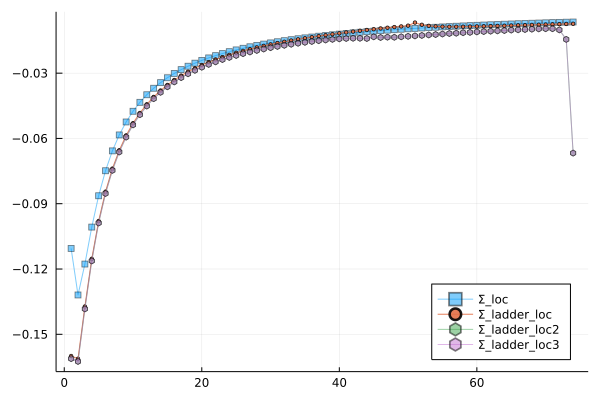

In [168]:
plot(imag(Σ_loc[1:size(Σ_ladder2,1)]), markershape=:square, alpha=0.5, markersize=3, label="Σ_loc", legend=:bottomright)
plot!(imag(Σ_ladderLoc), markershape=:circle, markersize=2, alpha=0.9, label="Σ_ladder_loc")
plot!(imag(Σ_ladderLoc2), markershape=:hexagon, markersize=3, alpha=0.5, label="Σ_ladder_loc2")
plot!(imag(Σ_ladderLoc3), markershape=:hexagon, markersize=3, alpha=0.5, label="Σ_ladder_loc3")

In [161]:
usable_ω = intersect(nlQ_ch.usable_ω, nlQ_sp.usable_ω)
usable_ω2 = intersect(nlQ_ch2.usable_ω, nlQ_sp2.usable_ω)
usable_ω3 = intersect(nlQ_ch3.usable_ω, nlQ_sp3.usable_ω)
usable_ω_common = intersect(usable_ω,usable_ω2,usable_ω3)
println("$(usable_ω) , $(usable_ω2), $(usable_ω_common)")
maximum(abs.(Σ_ladder_ω[usable_ω_common,:,:] .- Σ_ladder_ω2[usable_ω_common,:,:]))

39:63 , 7:95, 39:63


3.28444837029427

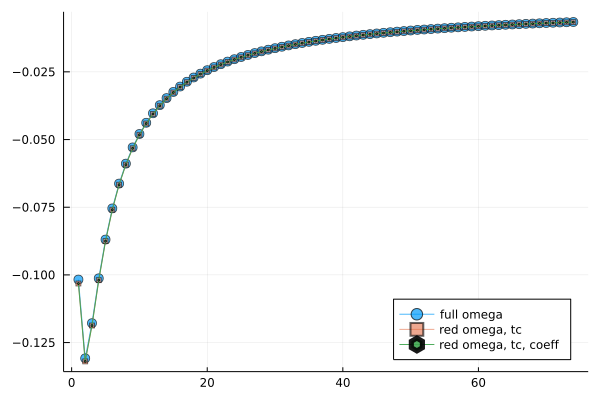

In [200]:
plot(imag(Σ_ladder_corrected[:,1]), markershape=:circle, markersize=5, alpha=0.7, label="full omega", legend=:bottomright)
plot!(imag(Σ_ladder_corrected2[:,1]), markershape=:square, markersize=2.5, alpha=0.6, label="red omega, tc")
plot!(imag(Σ_ladder_corrected3[:,1]), markershape=:hexagon, markersize=1, alpha=0.9, label="red omega, tc, coeff")

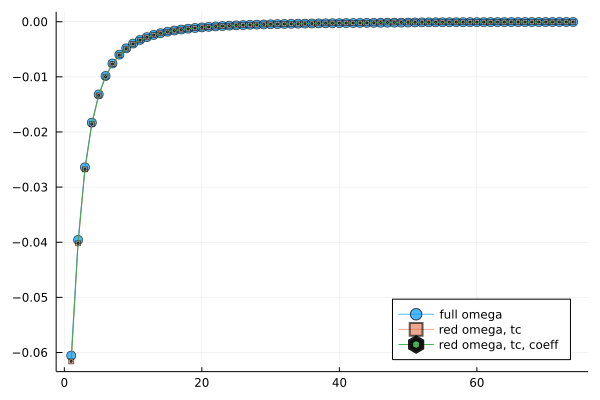

In [201]:
plot(real(Σ_ladder_corrected[:,1]), markershape=:circle, markersize=5, alpha=0.7, label="full omega", legend=:bottomright)
plot!(real(Σ_ladder_corrected2[:,1]), markershape=:square, markersize=2.5, alpha=0.6, label="red omega, tc")
plot!(real(Σ_ladder_corrected3[:,1]), markershape=:hexagon, markersize=1, alpha=0.9, label="red omega, tc, coeff")